
#***SUBMISSION OPREC KOMATIK DMAI 2026/2027***
---
**Nama:** Andi Nabil Safaraz

**NIM:** 25/560270/PA/23603

# **Tujuan**
Dalam kompetisi ini, peserta ditantang untuk memprediksi precipitation probability (%) menggunakan data cuaca historis.

# **Metrik**
Submisi akan dievaluasi menggunakan metrik Root Mean Squared Error (RMSE). RMSE mengukur rata-rata dari akar kuadrat selisih antara nilai prediksi dan nilai aktual. Metrik ini cocok untuk kasus regresi karena memberikan penalti yang lebih tinggi untuk kesalahan prediksi yang besar.

In [ ]:
!pip install CatBoost
!pip install optuna
!pip install optuna-integration[xgboost]

# 0. Import Libraries

In [ ]:
# Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

from datetime import datetime

# Preprocessing
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import VotingRegressor

# Model
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Hyperparameter
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Metrics
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
plt.style.use('bmh')

In [ ]:
pd.set_option('display.max_columns', None)

# 1. Import Datasets

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/dmai-oprec-2025/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/dmai-oprec-2025/test.csv')
sample_submission = pd.read_csv('/content/drive/MyDrive/dmai-oprec-2025/sample_submission.csv')

##  1.1 *Understanding Data* Awal
Disini saya ingin mengetahui *basic* dari *dataset* dimanasaya akan melihat ```.shape```, ```.info```, ```.head```, dan ```.describe``` agar saya dapat memahami bagaimana kondisi dari data sebelum menuju eksplorasi data lebih dalam.

In [ ]:
# Shape
print("df_train: ", df_train.shape)
print("df_test: ", df_test.shape)
print("sample_submission: ", sample_submission.shape)

df_train:  (6528, 43)
df_test:  (2112, 42)
sample_submission:  (2112, 2)


In [ ]:
# Features and Types
df_train.info()
print("")
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6528 entries, 0 to 6527
Data columns (total 43 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               6528 non-null   object 
 1   time                             6528 non-null   object 
 2   temperature_2m (°C)              6528 non-null   float64
 3   relative_humidity_2m (%)         5769 non-null   float64
 4   dew_point_2m (°C)                6528 non-null   float64
 5   apparent_temperature (°C)        6528 non-null   float64
 6   precipitation (mm)               6528 non-null   float64
 7   rain (mm)                        6528 non-null   float64
 8   showers (mm)                     6528 non-null   float64
 9   snowfall (cm)                    6528 non-null   float64
 10  snow_depth (m)                   6528 non-null   float64
 11  weather_code (wmo code)          6528 non-null   float64
 12  pressure_msl (hPa)  

Saya merasa bahwa tipe data dari masing-masing kolom sudah memiliki tipe yang tepat, namun saya ingin melihat lebih lanjut apakah ```weather_category``` pada kedua dataset dapat digunakan ***label encoding***.

In [ ]:
print("df_train: ")
display(df_train.head())
print("")
print("df_test: ")
display(df_test.head())

df_train: 


ID                 time  temperature_2m (°C)  \
0  region 1_2025-11-17_00  2025-11-17 00:00:00                 21.9   
1  region 2_2025-11-17_00  2025-11-17 00:00:00                 25.4   
2  region 3_2025-11-17_00  2025-11-17 00:00:00                 25.1   
3  region 4_2025-11-17_00  2025-11-17 00:00:00                 23.7   
4  region 5_2025-11-17_00  2025-11-17 00:00:00                 25.7   

   relative_humidity_2m (%)  dew_point_2m (°C)  apparent_temperature (°C)  \
0                      96.0               21.2                       25.8   
1                       NaN               24.4                       31.4   
2                      95.0               24.2                       31.1   
3                      96.0               23.0                       28.5   
4                      90.0               23.9                       31.6   

   precipitation (mm)  rain (mm)  showers (mm)  snowfall (cm)  snow_depth (m)  \
0                 0.0        0.0           0.0            0.0             0.0   
1                 0.0        0.0           0.0            0.0             0.0   
2                 0.0        0.0           0.0            0.0             0.0   
3                 0.0        0.0           0.0            0.0             0.0   
4                 0.0        0.0           0.0            0.0             0.0   

   weather_code (wmo code)  pressure_msl (hPa)  surface_pressure (hPa)  \
0                     45.0              1012.4                   969.2   
1                      3.0              1011.2                  1004.9   
2                      3.0              1011.2                   998.6   
3                      3.0              1011.5                   993.1   
4                      3.0              1010.8                  1005.4   

   cloud_cover (%)  cloud_cover_mid (%)  cloud_cover_low (%)  visibility (m)  \
0            100.0                 48.0                 51.0          1100.0   
1            100.0                 43.0                 73.0         24140.0   
2            100.0                 12.0                 53.0         24140.0   
3            100.0                  8.0                 61.0         24140.0   
4              NaN                 22.0                 60.0         24140.0   

   evapotranspiration (mm)  et0_fao_evapotranspiration (mm)  \
0                     0.01                              0.0   
1                     0.01                              0.0   
2                    -0.00                              0.0   
3                    -0.00                              0.0   
4                    -0.00                              0.0   

   vapour_pressure_deficit (kPa)  wind_speed_10m (m/s)  wind_speed_80m (m/s)  \
0                           0.10                  1.06                  1.86   
1                           0.19                  0.64                  1.35   
2                           0.16                   NaN                  0.98   
3                           0.12                  1.14                  2.44   
4                           0.33                  0.28                  1.20   

   wind_speed_120m (m/s)  wind_speed_180m (m/s)  wind_direction_10m (°)  \
0                   2.06                   2.28                   319.0   
1                   1.56                   1.84                   321.0   
2                   1.22                   1.61                   338.0   
3                   2.88                   3.54                   232.0   
4                   1.81                   2.30                   315.0   

   wind_direction_80m (°)  wind_direction_120m (°)  wind_direction_180m (°)  \
0                   306.0                    299.0                    293.0   
1                   312.0                    310.0                    299.0   
2                   294.0                    279.0                    277.0   
3                   235.0                    236.0                    241.0   
4             


df_test: 


ID                 time  temperature_2m (°C)  \
0  region 1_2025-12-21_00  2025-12-21 00:00:00                 22.2   
1  region 2_2025-12-21_00  2025-12-21 00:00:00                 25.2   
2  region 3_2025-12-21_00  2025-12-21 00:00:00                 25.6   
3  region 4_2025-12-21_00  2025-12-21 00:00:00                 24.1   
4  region 5_2025-12-21_00  2025-12-21 00:00:00                 25.6   

   relative_humidity_2m (%)  dew_point_2m (°C)  apparent_temperature (°C)  \
0                      98.0               21.9                       26.8   
1                      96.0               24.5                       31.3   
2                      94.0               24.6                       31.7   
3                      96.0               23.4                       29.5   
4                      95.0               24.7                       31.6   

   precipitation (mm)  rain (mm)  showers (mm)  snowfall (cm)  snow_depth (m)  \
0                 0.0        0.0           0.0            0.0             0.0   
1                 0.0        0.0           0.0            0.0             0.0   
2                 0.0        0.0           0.0            0.0             0.0   
3                 0.0        0.0           0.0            0.0             0.0   
4                 0.0        0.0           0.0            0.0             0.0   

   weather_code (wmo code)  pressure_msl (hPa)  surface_pressure (hPa)  \
0                     45.0              1009.3                   966.3   
1                     45.0              1007.9                  1001.6   
2                      3.0              1008.2                   995.6   
3                     45.0              1008.5                   990.2   
4                      3.0              1007.8                  1002.4   

   cloud_cover (%)  cloud_cover_mid (%)  cloud_cover_low (%)  visibility (m)  \
0            100.0                 40.0                 69.0         22520.0   
1            100.0                 50.0                 57.0         12600.0   
2              NaN                 34.0                 79.0         24140.0   
3            100.0                 30.0                 61.0         24140.0   
4            100.0                 83.0                 76.0         23840.0   

   evapotranspiration (mm)  et0_fao_evapotranspiration (mm)  \
0                    -0.00                              0.0   
1                     0.01                              0.0   
2                     0.02                              0.0   
3                     0.01                              0.0   
4                     0.02                              0.0   

   vapour_pressure_deficit (kPa)  wind_speed_10m (m/s)  wind_speed_80m (m/s)  \
0                           0.05                  0.50                  0.86   
1                           0.13                  0.51                  0.92   
2                           0.20                  0.67                  1.25   
3                           0.12                  0.54                  0.89   
4                           0.16                  0.98                  1.57   

   wind_speed_120m (m/s)  wind_speed_180m (m/s)  wind_direction_10m (°)  \
0                   0.86                   0.81                    53.0   
1                   1.10                   1.30                   101.0   
2                   1.36                   1.00                    27.0   
3                   0.58                   0.14                   292.0   
4                   1.58                   1.20                    24.0   

   wind_direction_80m (°)  wind_direction_120m (°)  wind_direction_180m (°)  \
0                    54.0                     54.0                     60.0   
1                   103.0                     95.0                     86.0   
2                    29.0                     36.0                     53.0   
3                   297.0                    301.0                    315.0   
4             

Dapat dilihat bahwa ```weather_category``` dapat dijadikan encoding yang nanti akan memudahkan model.

In [ ]:
print("df_train: ")
display(df_train.describe())
print("")
print("df_test: ")
display(df_test.describe())

df_train: 


temperature_2m (°C)  relative_humidity_2m (%)  dew_point_2m (°C)  \
count          6528.000000               5769.000000        6528.000000   
mean             26.431020                 81.941931          22.918581   
std               2.600549                 10.889716           1.412155   
min              19.400000                 45.000000          17.100000   
25%              24.600000                 74.000000          22.100000   
50%              26.400000                 84.000000          23.100000   
75%              28.200000                 91.000000          23.900000   
max              34.600000                100.000000          26.300000   

       apparent_temperature (°C)  precipitation (mm)    rain (mm)  \
count                6528.000000         6528.000000  6528.000000   
mean                   30.939017            0.220175     0.006357   
std                     2.978665            0.759689     0.191966   
min                    21.600000            0.000000     0.000000   
25%                    29.200000            0.000000     0.000000   
50%                    31.100000            0.000000     0.000000   
75%                    32.800000            0.100000     0.000000   
max                    41.600000           13.900000    10.300000   

       showers (mm)  snowfall (cm)  snow_depth (m)  weather_code (wmo code)  \
count   6528.000000         6528.0          6528.0              6528.000000   
mean       0.213710            0.0             0.0                21.112592   
std        0.723332            0.0             0.0                32.887266   
min        0.000000            0.0             0.0                 0.000000   
25%        0.000000            0.0             0.0                 3.000000   
50%        0.000000            0.0             0.0                 3.000000   
75%        0.100000            0.0             0.0                45.000000   
max       13.900000            0.0             0.0                96.000000   

       pressure_msl (hPa)  surface_pressure (hPa)  cloud_cover (%)  \
count         6528.000000             6528.000000      5789.000000   
mean          1009.646507              996.310616        92.390223   
std              1.780650               11.740437        14.049372   
min           1003.700000              963.100000         3.000000   
25%           1008.500000              994.200000        90.000000   
50%           1009.700000              999.900000       100.000000   
75%           1010.800000             1003.800000       100.000000   
max           1015.600000             1011.300000       100.000000   

       cloud_cover_mid (%)  cloud_cover_low (%)  visibility (m)  \
count          6528.000000          6528.000000     6528.000000   
mean             39.143076            55.326746    21282.478554   
std              27.942313            19.598404     5610.265388   
min               0.000000             0.000000      240.000000   
25%              11.000000            45.000000    21860.000000   
50%              42.000000            57.000000    24140.000000   
75%              59.000000            69.000000    24140.000000   
max             100.000000           100.000000    24140.000000   

       evapotranspiration (mm)  et0_fao_evapotranspiration (mm)  \
count              6528.000000                      6528.000000   
mean                  0.145722                         0.162258   
std                   0.163123                         0.204000   
min                  -0.000000                         0.000000   
25%                   0.010000                         0.000000   
50%                   0.060000                         0.030000   
75%                   0.250000                         0.320000   
max                   0.670000                         0.760000   

       vapour_pressure_deficit (kPa)  wind_speed_10m (m/s)  \
count                    6528.000000           5826.000000   
mean                        0.6796


df_test: 


temperature_2m (°C)  relative_humidity_2m (%)  dew_point_2m (°C)  \
count          2112.000000               1869.000000        2112.000000   
mean             27.032339                 82.363296          23.561932   
std               2.792684                 11.815460           1.304400   
min              20.300000                 50.000000          18.600000   
25%              25.000000                 74.000000          22.800000   
50%              26.800000                 85.000000          23.800000   
75%              28.900000                 93.000000          24.400000   
max              34.600000                100.000000          26.600000   

       apparent_temperature (°C)  precipitation (mm)    rain (mm)  \
count                2112.000000         2112.000000  2112.000000   
mean                   32.115672            0.171165     0.004309   
std                     3.159358            0.473471     0.049968   
min                    22.900000            0.000000     0.000000   
25%                    30.100000            0.000000     0.000000   
50%                    32.200000            0.000000     0.000000   
75%                    34.000000            0.100000     0.000000   
max                    41.500000            5.200000     1.300000   

       showers (mm)  snowfall (cm)  snow_depth (m)  weather_code (wmo code)  \
count   2112.000000         2112.0          2112.0              2112.000000   
mean       0.166619            0.0             0.0                20.916667   
std        0.463932            0.0             0.0                32.189274   
min        0.000000            0.0             0.0                 0.000000   
25%        0.000000            0.0             0.0                 3.000000   
50%        0.000000            0.0             0.0                 3.000000   
75%        0.100000            0.0             0.0                45.000000   
max        5.200000            0.0             0.0                96.000000   

       pressure_msl (hPa)  surface_pressure (hPa)  cloud_cover (%)  \
count         2112.000000             2112.000000      1890.000000   
mean          1008.408286              995.117708        88.364021   
std              1.501369               11.634417        19.601881   
min           1004.500000              964.100000         0.000000   
25%           1007.400000              993.000000        83.000000   
50%           1008.500000              998.600000       100.000000   
75%           1009.400000             1002.600000       100.000000   
max           1012.700000             1008.600000       100.000000   

       cloud_cover_mid (%)  cloud_cover_low (%)  visibility (m)  \
count          2112.000000          2112.000000     2112.000000   
mean             29.795928            51.216383    21473.579545   
std              29.516016            20.454130     5432.708742   
min               0.000000             0.000000      320.000000   
25%               0.000000            40.000000    22020.000000   
50%              28.000000            53.000000    24140.000000   
75%              49.000000            65.000000    24140.000000   
max             100.000000           100.000000    24140.000000   

       evapotranspiration (mm)  et0_fao_evapotranspiration (mm)  \
count              2112.000000                      2112.000000   
mean                  0.150994                         0.170781   
std                   0.171100                         0.220297   
min                  -0.000000                         0.000000   
25%                   0.010000                         0.000000   
50%                   0.060000                         0.030000   
75%                   0.260000                         0.330000   
max                   0.610000                         0.750000   

       vapour_pressure_deficit (kPa)  wind_speed_10m (m/s)  \
count                    2112.000000           1917.000000   
mean                        0.7004

Saya melakukan ```.describe()``` agar dapat melihat outlier dan nilai ekstrem. Disini saya juga melihat pada kedua dataset terdapat kolom ```snowfall (cm)``` dan ```snow_depth (m)``` yang tidak memiliki nilai sama sekali (0), bisa saya drop karena hanya akan menjadi noise untuk model.

# 2. EDA

## 2.1 *Missing Values*
Saya melakukan visualisasi terhadap *missing values* yang ada agar lebih mudah dibaca, tujuan saya melakukannya untuk melihat apakah kedua dataset memiliki *missing value* yang konsisten.

### 2.1.1 Train

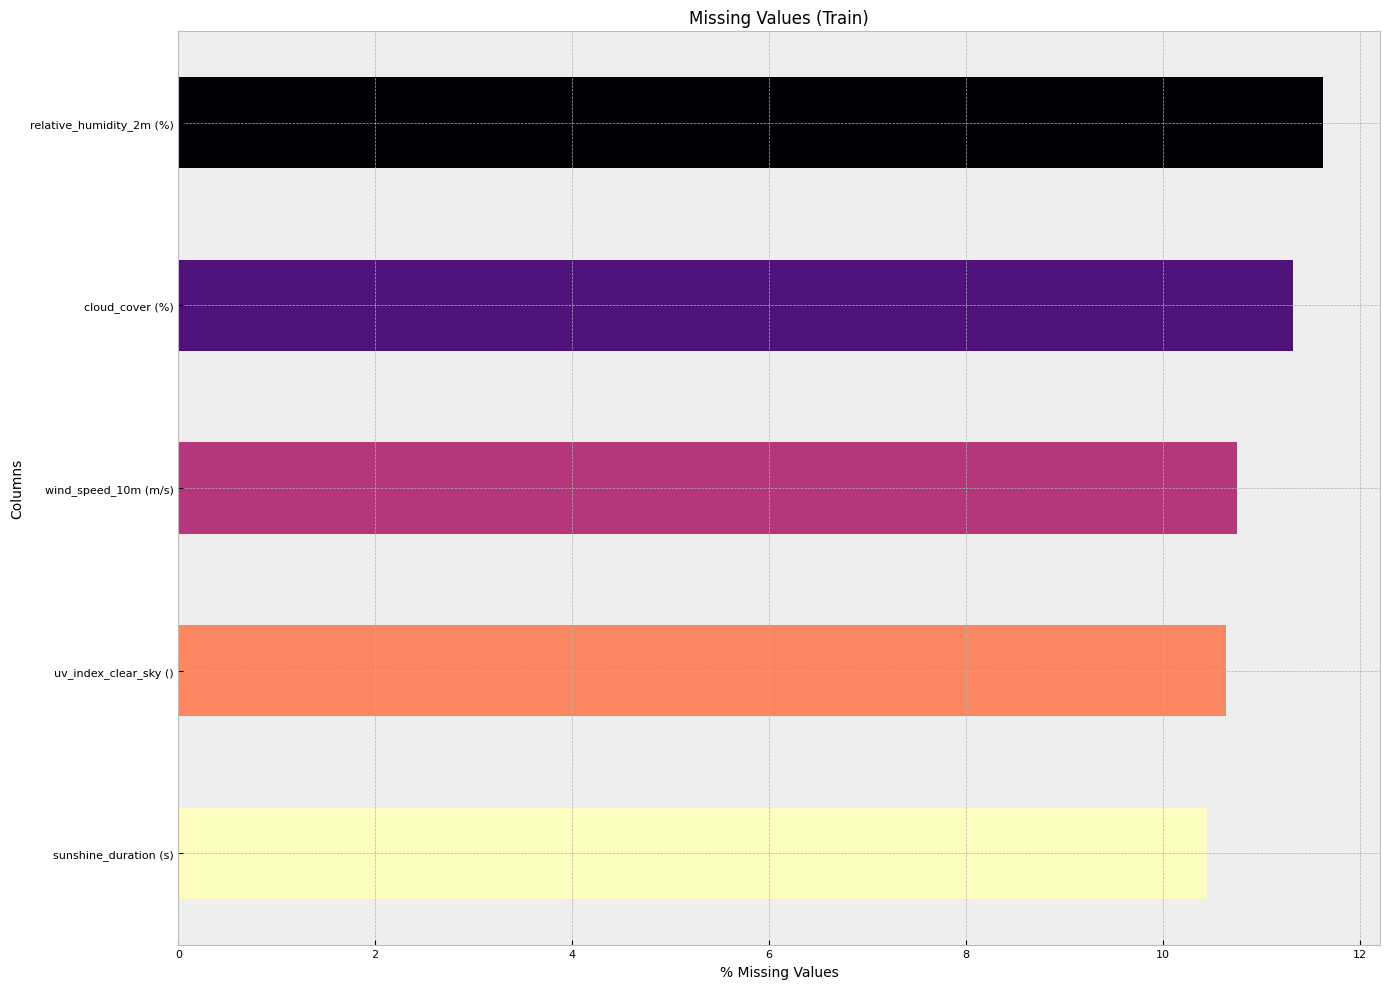

In [ ]:
missing_values = df_train.isnull().mean() * 100
missing_values = missing_values[missing_values > 0]
missing_values.sort_values(inplace=True)

plt.figure(figsize=(14, 10))
color_map = cm.get_cmap('magma_r', len(missing_values))
colors = color_map(range(len(missing_values)))
missing_values.plot(kind='barh', color=colors)
plt.title('Missing Values (Train)', fontsize=12)
plt.xlabel('% Missing Values', fontsize=10)
plt.ylabel('Columns', fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
missing_values.sort_values(ascending=False, inplace=True)
plt.tight_layout()
plt.show()

### 2.1.2 Test

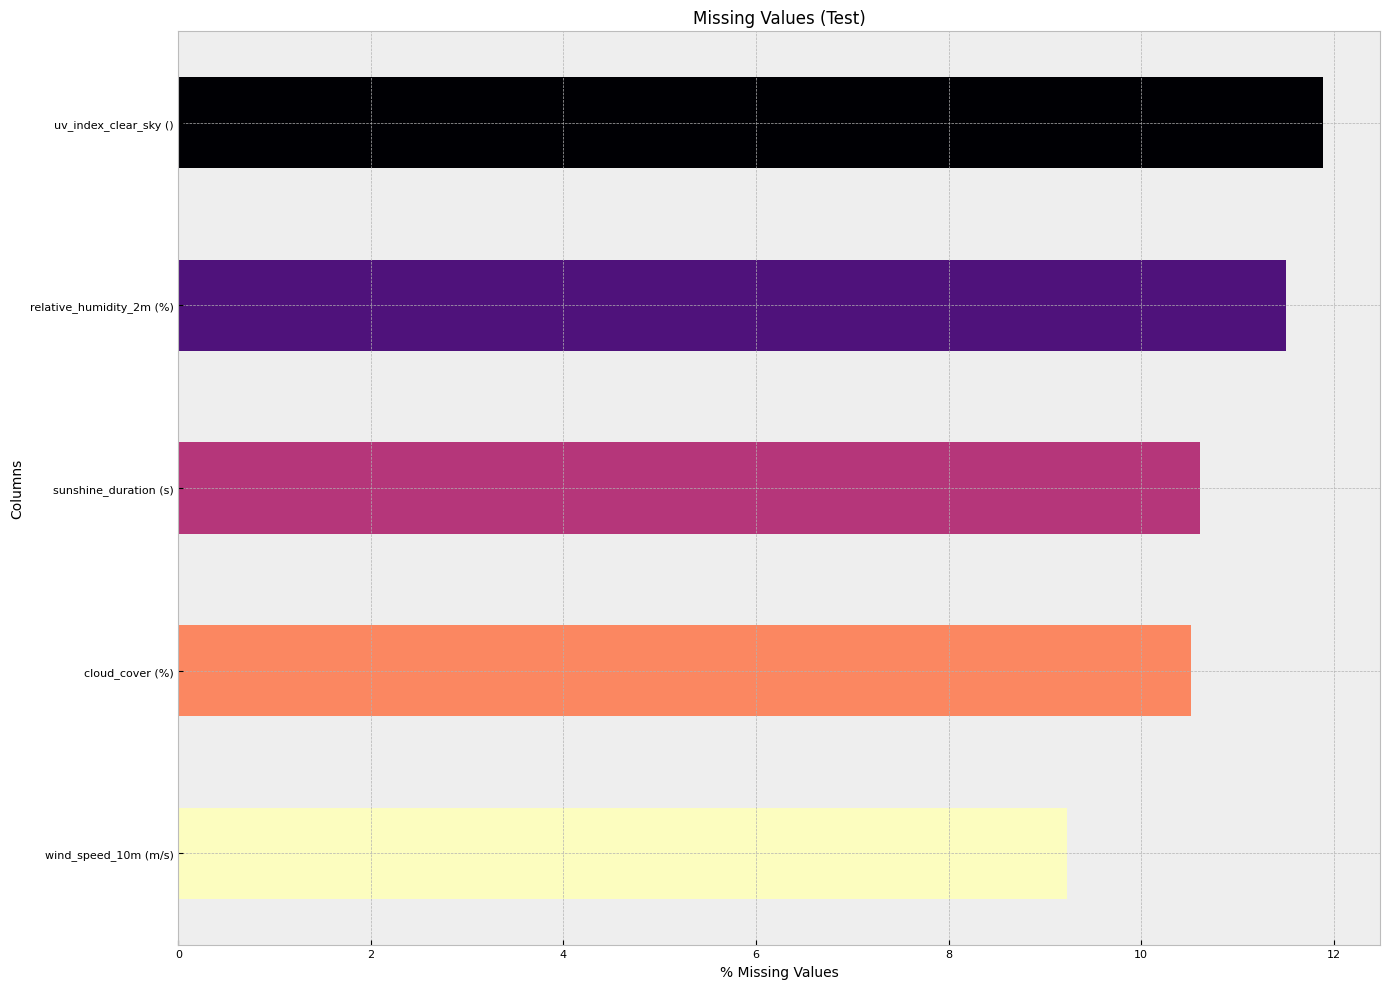

In [ ]:
missing_values = df_test.isnull().mean() * 100
missing_values = missing_values[missing_values > 0]
missing_values.sort_values(inplace=True)

plt.figure(figsize=(14, 10))
color_map = cm.get_cmap('magma_r', len(missing_values))
colors = color_map(range(len(missing_values)))
missing_values.plot(kind='barh', color=colors)
plt.title('Missing Values (Test)', fontsize=12)
plt.xlabel('% Missing Values', fontsize=10)
plt.ylabel('Columns', fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
missing_values.sort_values(ascending=False, inplace=True)
plt.tight_layout()
plt.show()

Disini saya melihat bahwa ada 5 kolom yang memiliki *missing values* yaitu `relative_humidity_2m`, `cloud_cover`, `wind_speed_10m`, `uv_index_clear_sky`, dan `sunshine_duration`. Ternyata polanya sama di train dan test artinya bukan missing tidak berpola. Karena polanya konsisten, penggunaaan metode *linear interpolation* per region adalah pendekatan yang tepat.

#### 2.1.1.1 *Basic Cleaning* (Numerikal)
Disini saya akan imputasi ```relative_humidity_2m (%), cloud_cover (%), wind_speed_10m (m/s), uv_index_clear_sky (), sunshine_duration (s)``` menggunakan metode *linear interpolation*.

In [ ]:
missing_cols = ['relative_humidity_2m (%)', 'cloud_cover (%)', 'wind_speed_10m (m/s)', 'uv_index_clear_sky ()', 'sunshine_duration (s)']

In [ ]:
for df in [df_train, df_test]:
    for col in missing_cols:
      df[col] = df.groupby('region')[col].transform(
        lambda x: x.interpolate(method='linear', limit_direction='both')
      )
      df.fillna(method='bfill', inplace=True) # Agar tidak ada missing yang tersisa
      df.fillna(method='ffill', inplace=True)
print('Missing values setelah imputation:', df.isnull().sum().sum())

Missing values setelah imputation: 0


Kemudian saya akan benar-benar melihat kembali apakah kedua dataset sudah terimputasi

In [ ]:
df_train.isnull().sum()

ID                                 0
time                               0
temperature_2m (°C)                0
relative_humidity_2m (%)           0
dew_point_2m (°C)                  0
apparent_temperature (°C)          0
precipitation (mm)                 0
rain (mm)                          0
showers (mm)                       0
snowfall (cm)                      0
snow_depth (m)                     0
weather_code (wmo code)            0
pressure_msl (hPa)                 0
surface_pressure (hPa)             0
cloud_cover (%)                    0
cloud_cover_mid (%)                0
cloud_cover_low (%)                0
visibility (m)                     0
evapotranspiration (mm)            0
et0_fao_evapotranspiration (mm)    0
vapour_pressure_deficit (kPa)      0
wind_speed_10m (m/s)               0
wind_speed_80m (m/s)               0
wind_speed_120m (m/s)              0
wind_speed_180m (m/s)              0
wind_direction_10m (°)             0
wind_direction_80m (°)             0
wind_direction_120m (°)            0
wind_direction_180m (°)            0
wind_gusts_10m (m/s)               0
temperature_80m (°C)               0
temperature_120m (°C)              0
temperature_180m (°C)              0
cloud_cover_high (%)               0
uv_index ()                        0
uv_index_clear_sky ()              0
sunshine_duration (s)              0
wet_bulb_temperature_2m (°C)       0
freezing_level_height (m)          0
boundary_layer_height (m)          0
region                             0
weather_category                   0
precipitation_probability (%)      0
dtype: int64

In [ ]:
df_test.isnull().sum()

ID                                 0
time                               0
temperature_2m (°C)                0
relative_humidity_2m (%)           0
dew_point_2m (°C)                  0
apparent_temperature (°C)          0
precipitation (mm)                 0
rain (mm)                          0
showers (mm)                       0
snowfall (cm)                      0
snow_depth (m)                     0
weather_code (wmo code)            0
pressure_msl (hPa)                 0
surface_pressure (hPa)             0
cloud_cover (%)                    0
cloud_cover_mid (%)                0
cloud_cover_low (%)                0
visibility (m)                     0
evapotranspiration (mm)            0
et0_fao_evapotranspiration (mm)    0
vapour_pressure_deficit (kPa)      0
wind_speed_10m (m/s)               0
wind_speed_80m (m/s)               0
wind_speed_120m (m/s)              0
wind_speed_180m (m/s)              0
wind_direction_10m (°)             0
wind_direction_80m (°)             0
wind_direction_120m (°)            0
wind_direction_180m (°)            0
wind_gusts_10m (m/s)               0
temperature_80m (°C)               0
temperature_120m (°C)              0
temperature_180m (°C)              0
cloud_cover_high (%)               0
uv_index ()                        0
uv_index_clear_sky ()              0
sunshine_duration (s)              0
wet_bulb_temperature_2m (°C)       0
freezing_level_height (m)          0
boundary_layer_height (m)          0
region                             0
weather_category                   0
dtype: int64

## Konversi Waktu untuk EDA

In [ ]:
# Konversi time to datetime
df_train['time'] = pd.to_datetime(df_train['time'])
df_test['time'] = pd.to_datetime(df_test['time'])

# Sort dari masing-masing region dan waktu
df_train = df_train.sort_values(['region', 'time']).reset_index(drop=True)
df_test = df_test.sort_values(['region', 'time']).reset_index(drop=True)

## 2.2 Distribusi Target

In [ ]:
target = 'precipitation_probability (%)'

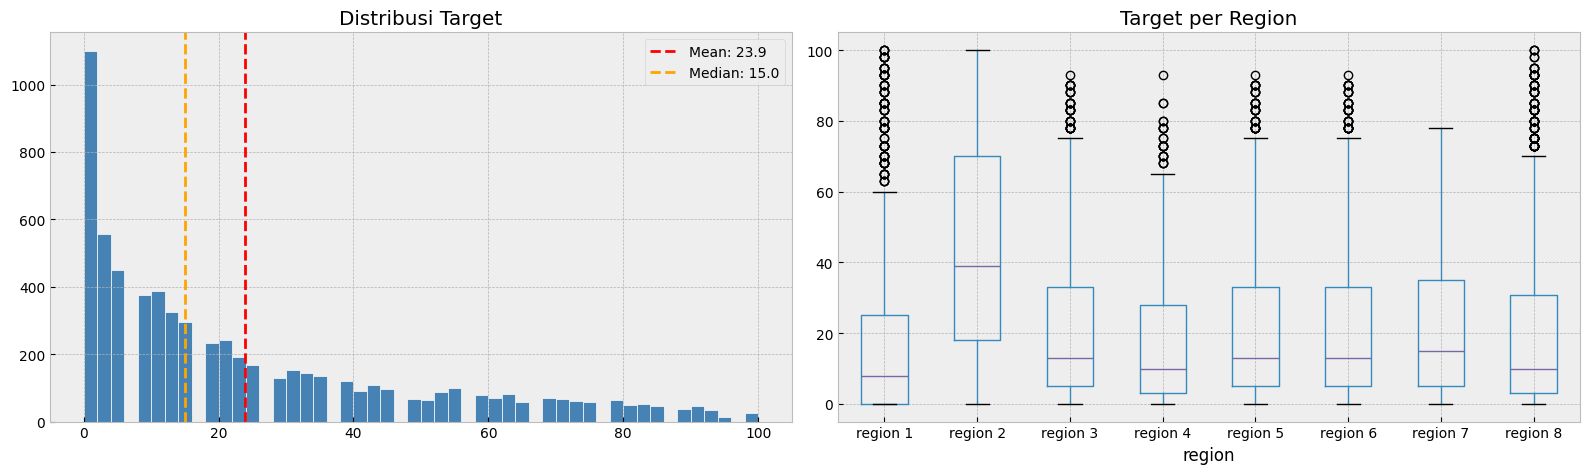

count    6528.000000
mean       23.867034
std        25.053895
min         0.000000
25%         3.000000
50%        15.000000
75%        38.000000
max       100.000000
Name: precipitation_probability (%), dtype: float64


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
axes[0].hist(df_train[target], bins=50, color='steelblue', edgecolor='white')
axes[0].axvline(df_train[target].mean(),   color='red',    linestyle='--', label=f'Mean: {df_train[target].mean():.1f}')
axes[0].axvline(df_train[target].median(), color='orange', linestyle='--', label=f'Median: {df_train[target].median():.1f}')
axes[0].set_title('Distribusi Target')
axes[0].legend()

df_train.boxplot(column=target, by='region', ax=axes[1])
axes[1].set_title('Target per Region')
plt.suptitle('')
plt.tight_layout()
plt.show()

print(df_train[target].describe())

Saya melihat bahwa target (```precipitation_probability (%)```) sangat *right skewed* dan karakteristik per Region yang berbeda.

## 2.3 Deret Waktu dari Precipitation Probability per Region

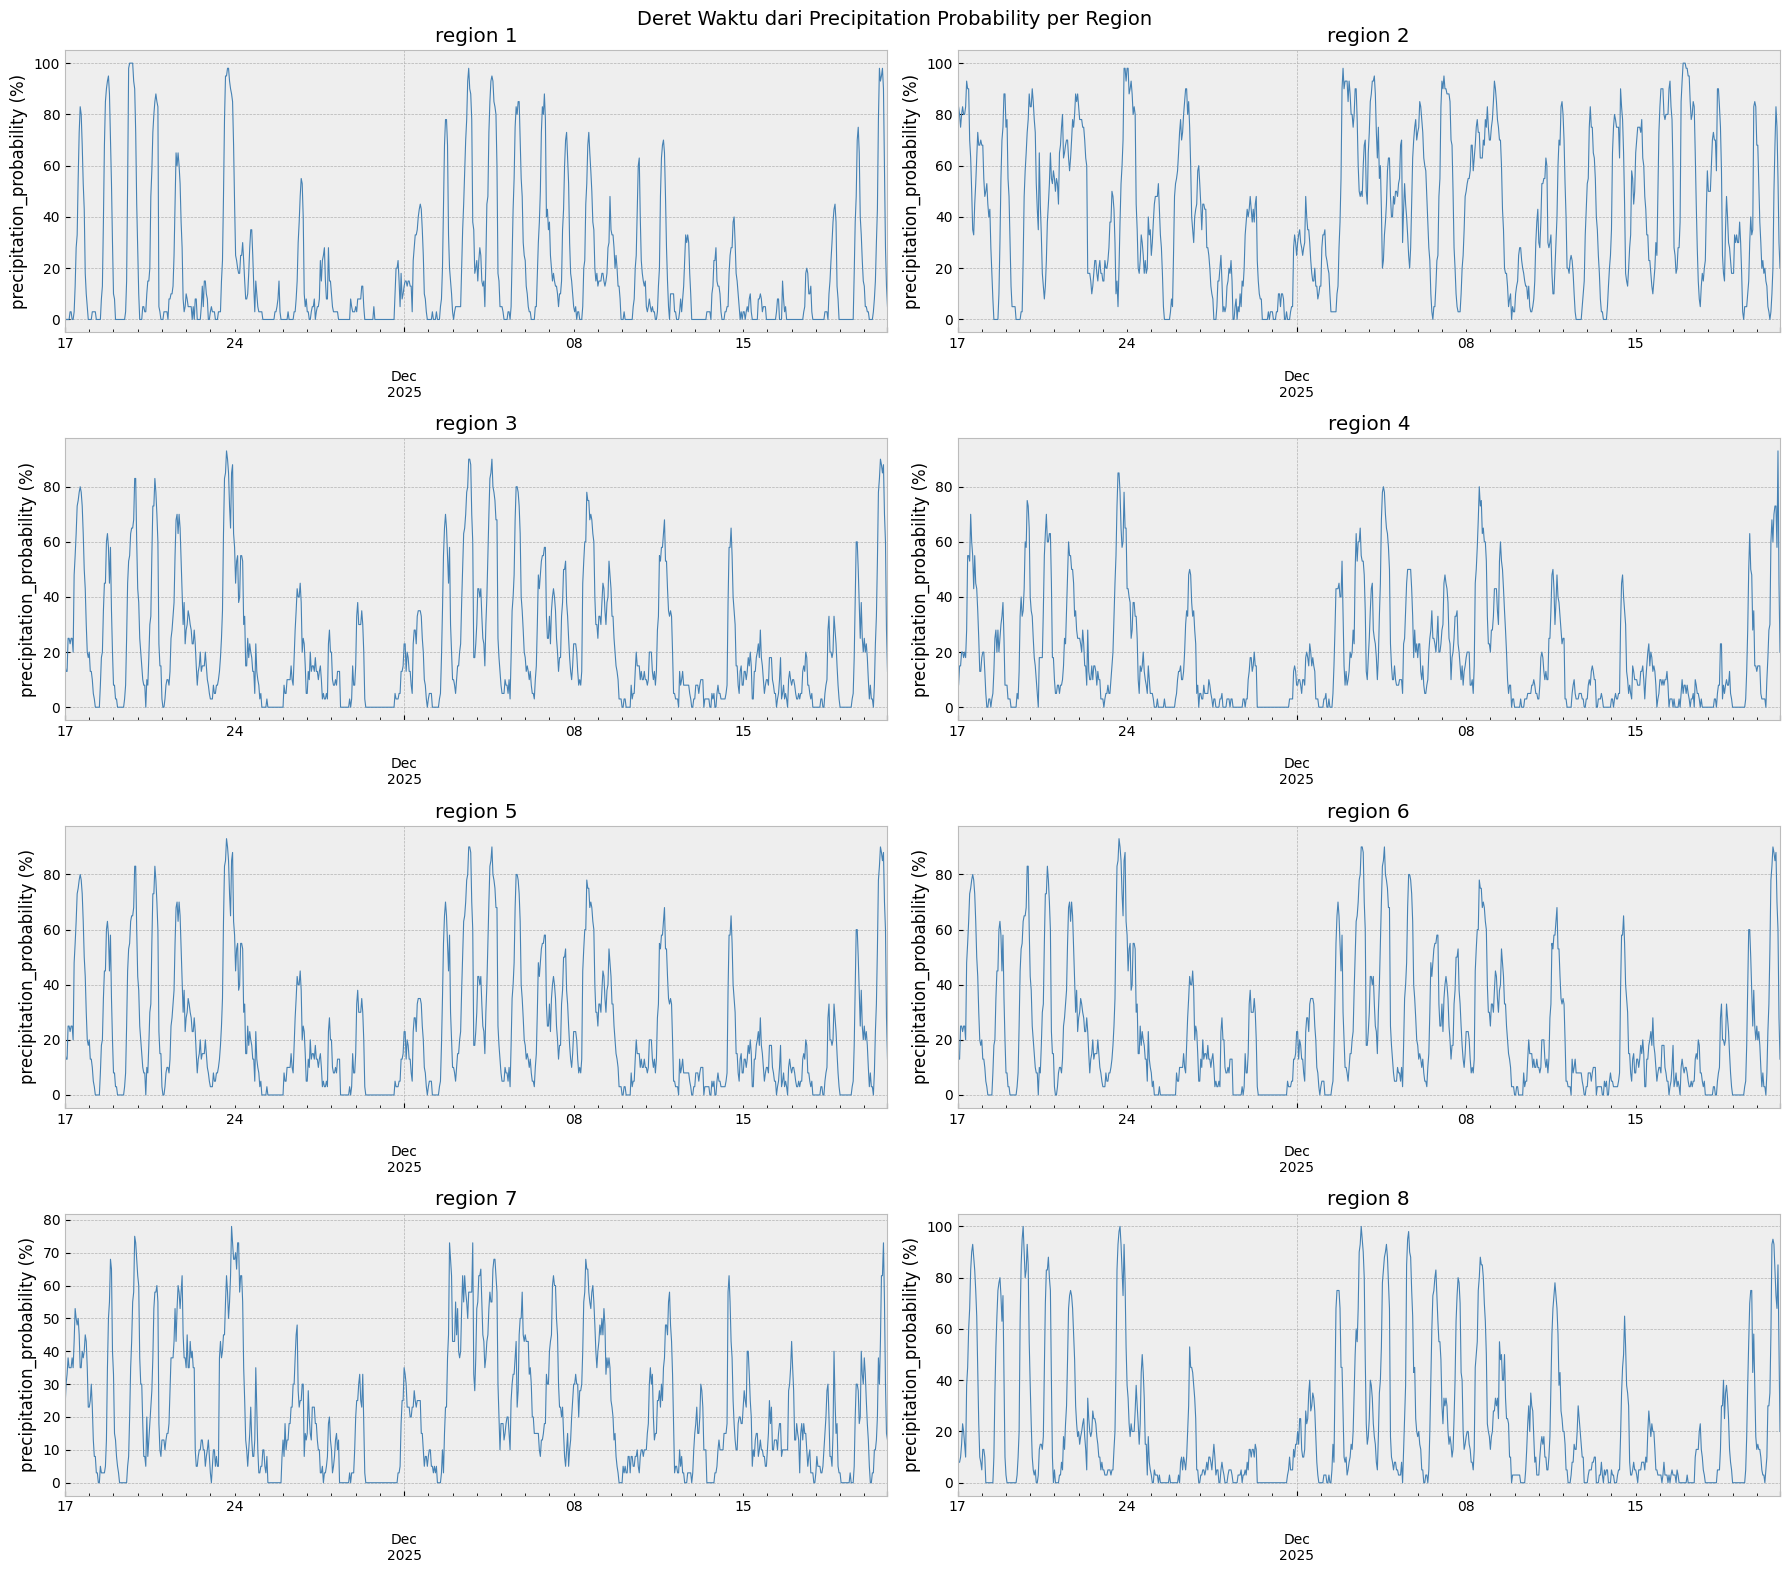

In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(18, 16))
for i, region in enumerate(sorted(df_train['region'].unique())):
    ax = axes[i//2][i%2]
    df_train[df_train['region']==region].set_index('time')[target].plot(ax=ax, linewidth=0.8, color='steelblue')
    ax.set_title(region)
    ax.set_ylabel('precipitation_probability (%)')
    ax.set_xlabel('')
plt.suptitle('Deret Waktu dari Precipitation Probability per Region', fontsize=14)
plt.tight_layout()
plt.show()

Setiap region menunjukkan pola fluktuasi harian yang jelas dimana probabilitas hujan tinggi di jam-jam tertentu lalu turun. Ini mengkonfirmasi bahwa **fitur jam (hour_sin/cos)** dan **lag temporal** akan sangat berguna. Tidak ada anomali di data.

## 2.4 Pola Jam

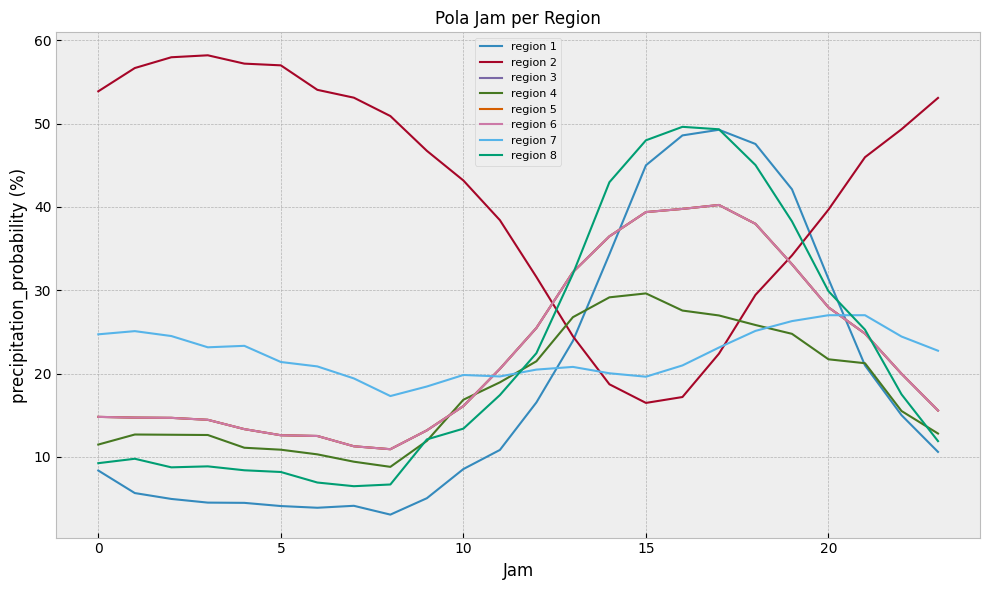

In [ ]:
df_hour = df_train.copy()
df_hour['hour'] = df_hour['time'].dt.hour

fig, ax = plt.subplots(figsize=(10, 6))
for region in sorted(df_hour['region'].unique()):
    df_hour[df_hour['region']==region].groupby('hour')[target].mean().plot(ax=ax, label=region, linewidth=1.5)
ax.legend(fontsize=8)
plt.title('Pola Jam per Region', fontsize=12)
ax.set_ylabel('precipitation_probability (%)')
ax.set_xlabel('Jam')

plt.tight_layout()
plt.show()

Ada pola diurnal yang jelas karena probabilitas hujan cenderung lebih tinggi di sore-malam hari. Pola ini konsisten di semua region, meskipun timing-nya sedikit berbeda. Ini mengkonfirmasi pentingnya fitur jam dan menjadi justifikasi kuat untuk cyclic encoding (sin/cos) bukan integer biasa.

## 2.5 Weather Category vs Target
Visualisasi ini saya lakukan guna untuk melihat apakah ```weather_category``` akan di encoding menggunakan label atau ordinal.

Mean target per weather_category (URUTAN AKTUAL DATA):
                         mean    std  count
weather_category                           
Clouds forming          13.42  17.71   2016
Fog or ice fog          17.82  22.65    120
Rain shower slight      24.01  23.03   2040
Thunderstorm with hail  31.51  30.11    696
Thunderstorm no hail    33.63  27.70   1656


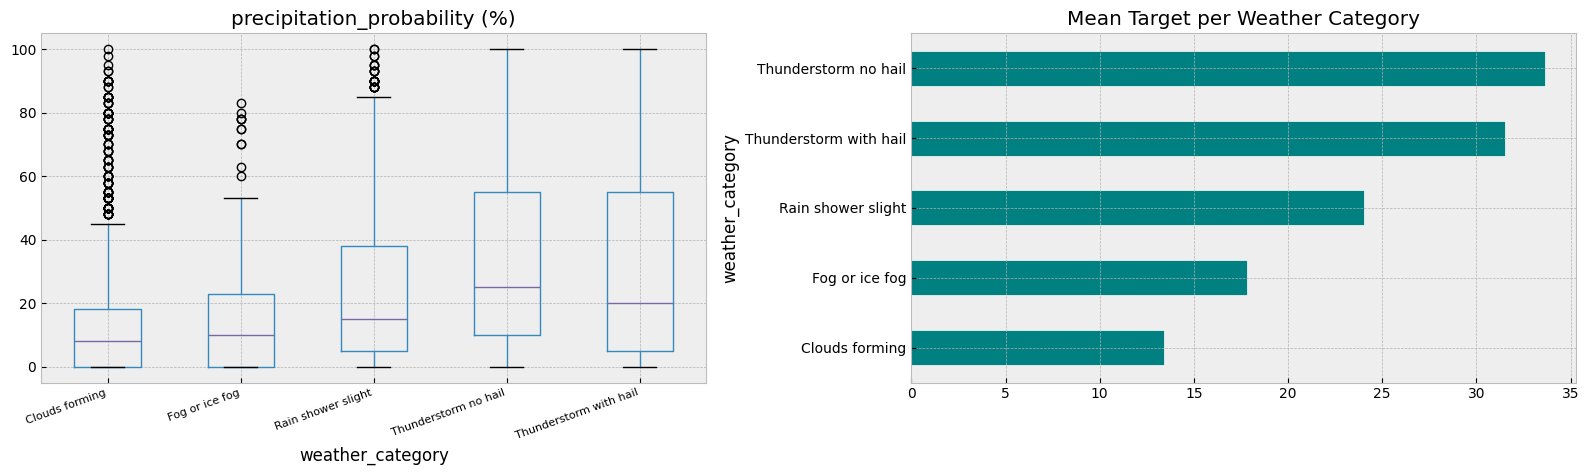

In [57]:
wc_stats = df_train.groupby('weather_category')[target].agg(['mean','std','count']).sort_values('mean')
print('Mean target per weather_category (URUTAN AKTUAL DATA):')
print(wc_stats.round(2))

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
df_train.boxplot(column=target, by='weather_category', ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=20, ha='right', fontsize=8)
plt.suptitle('')
wc_stats['mean'].plot(kind='barh', ax=axes[1], color='teal', edgecolor='white')
axes[1].set_title('Mean Target per Weather Category')
plt.tight_layout()
plt.show()

Dapat dilihat bahwa ```weather_category``` memiliki sebuah urutan yang ordinal sehingga penggunaan Ordinal Encoder merupakan cara yang tepat.

## 2.6 Heatmap

In [ ]:
numeric_df = df_train.select_dtypes(include=['number'])
corr_matrix = numeric_df.corr()

<Axes: >

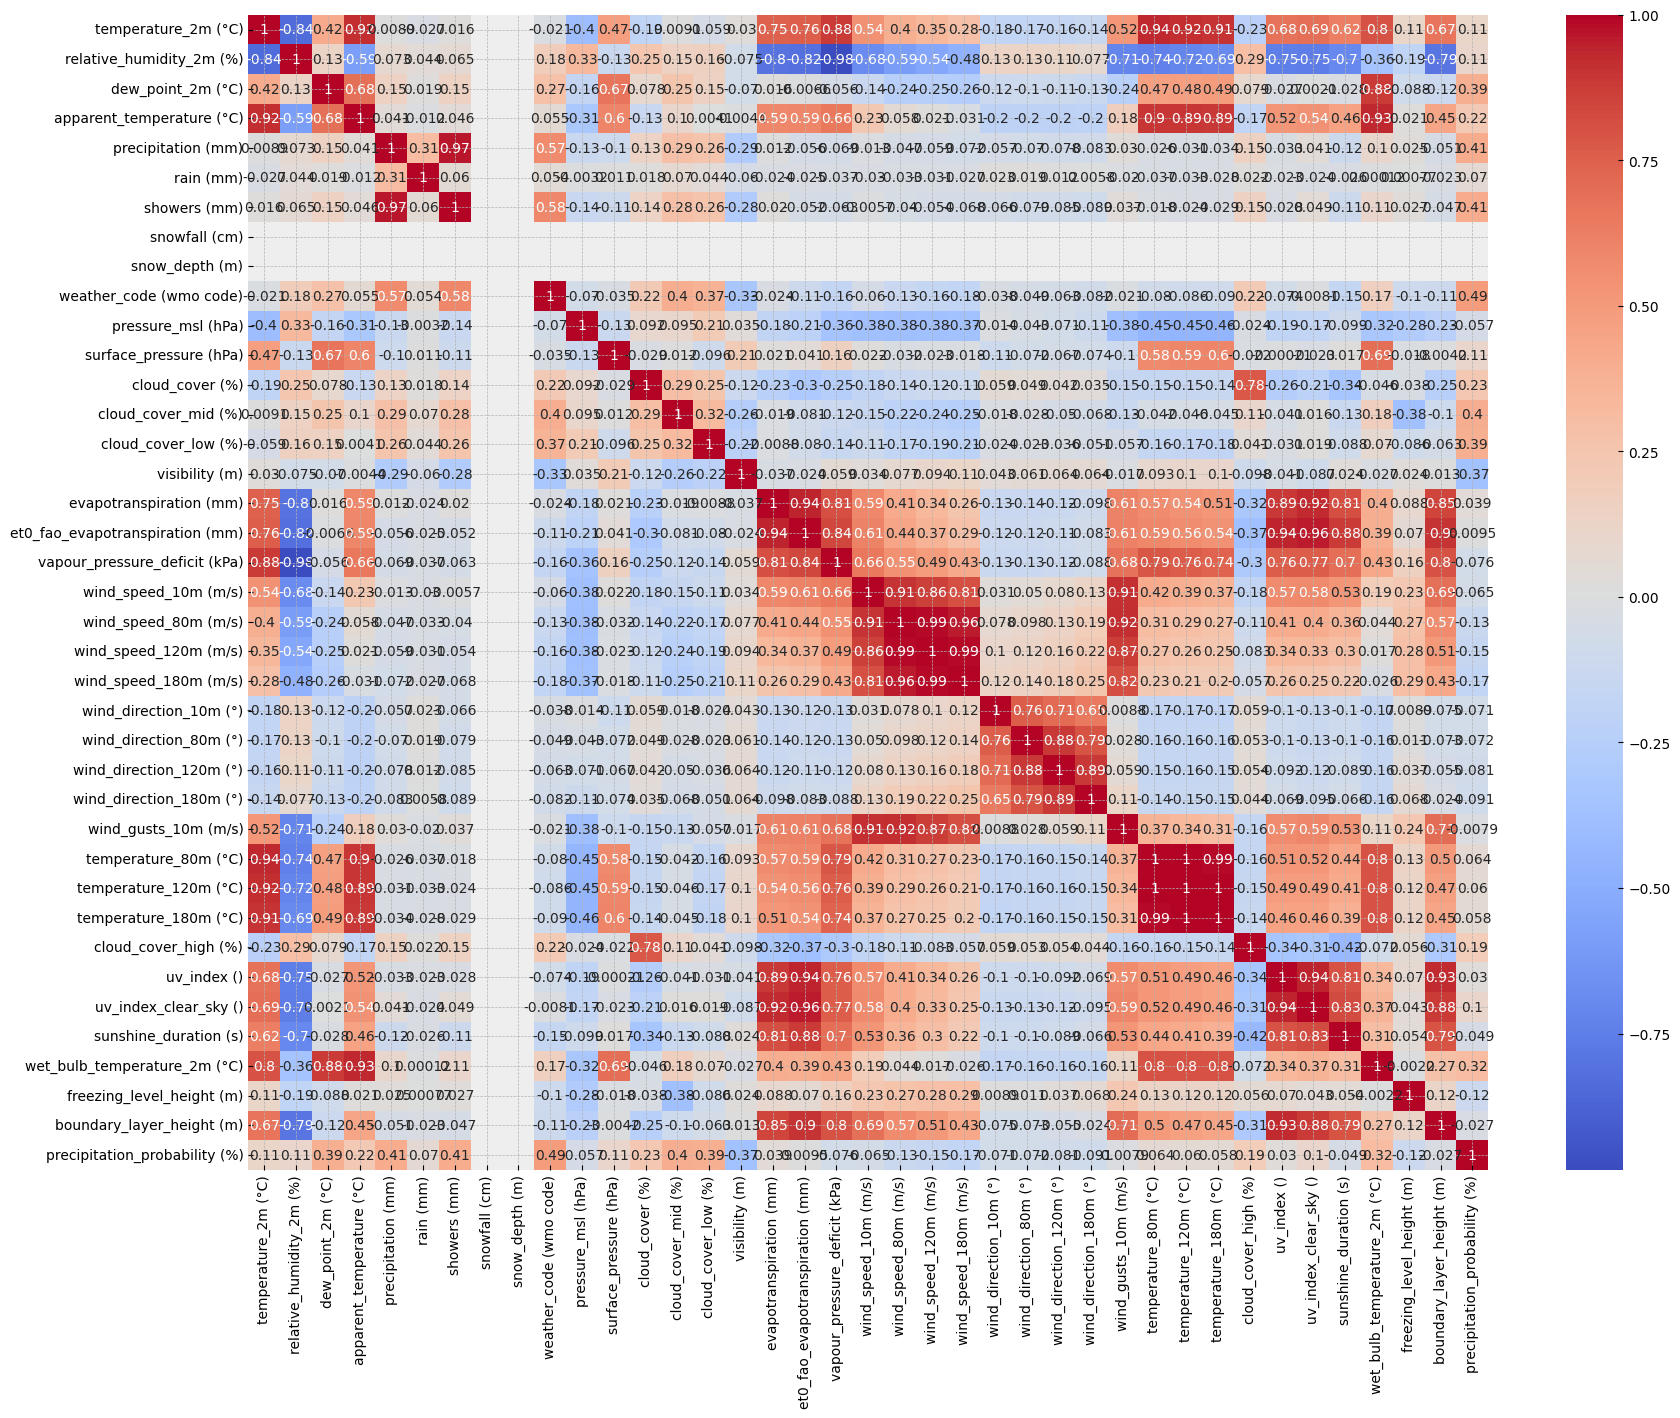

In [ ]:
data_Heatmap = df_train.select_dtypes(include='number')
plt.figure(figsize=(20, 15))
sns.heatmap(data_Heatmap.corr(), annot = True, cmap='coolwarm')

Pertama saya ingin melihat terlebih dahulu garis besar dari semua korelasi yang ada pada semua kolom dengan begitu saya dapat melihat mana fitur yang berkorelasi tinggi dengan ```precipitation_probability (%)``` maupun fitur multikolinearitas.

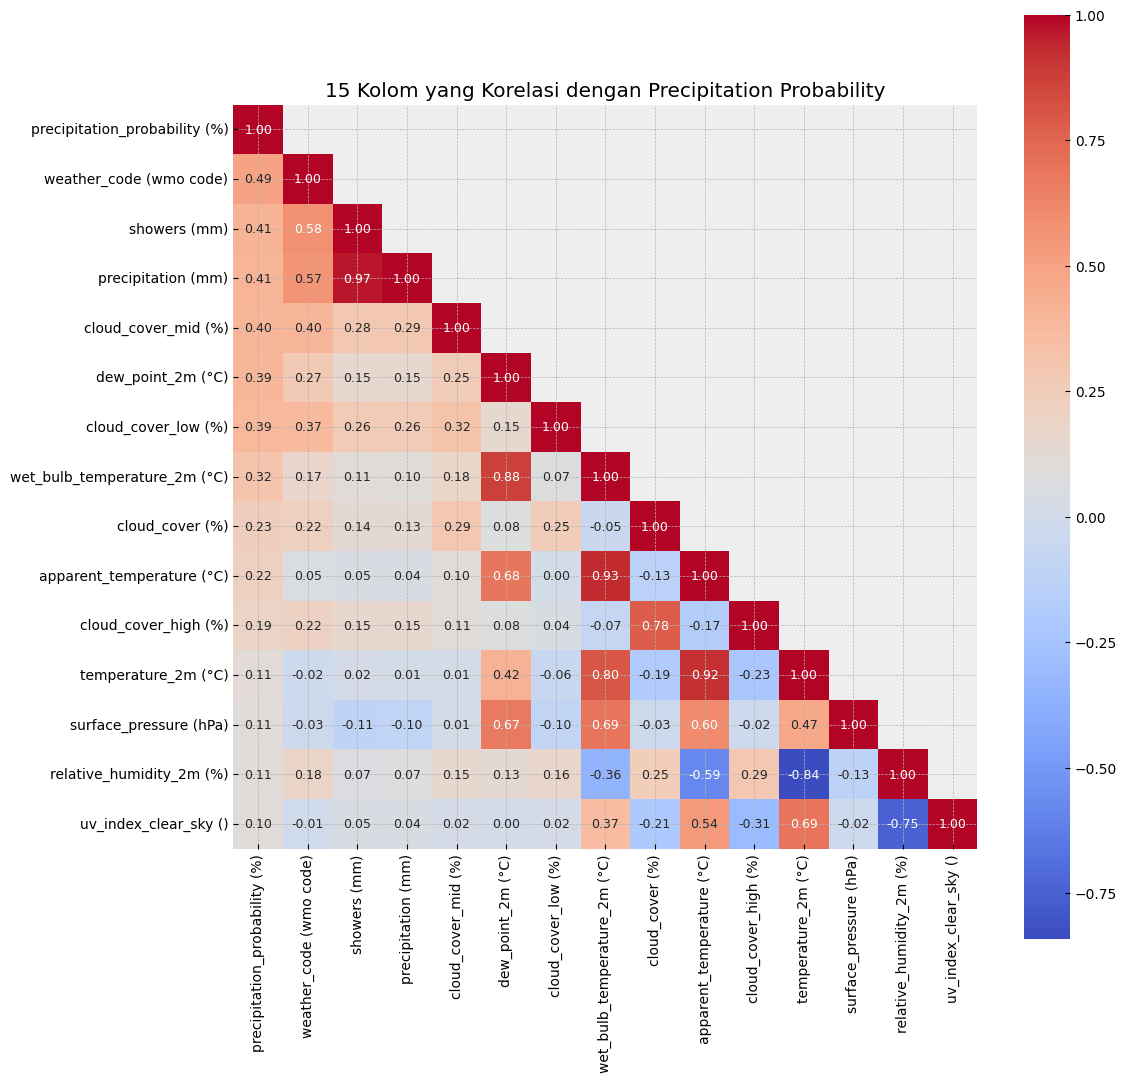

In [ ]:
k = 15
cols = corr_matrix.nlargest(k, 'precipitation_probability (%)')['precipitation_probability (%)'].index
cm = df_train[cols].corr()

mask = np.triu(np.ones_like(cm, dtype=bool), k = 1)
plt.figure(figsize=(12, 12))

sns.heatmap(
    cm,
    mask=mask,
    cbar=True,
    annot=True,
    square=True,
    fmt='.2f',
    annot_kws={'size': 9},
    cmap='coolwarm'
)
plt.title(f'15 Kolom yang Korelasi dengan Precipitation Probability')
plt.show()

Saya kemudian ingin melihat 15 fitur tertinggi yang berkorelasi dengan ```precipitation_probability (%)``` dengan top 5 fitur yaitu ```weather_code, showers (mm), precipitation (mm), cloud_cover_mid,``` dan ```dew_point_2m```. Ini menjadi referensi feature importance awal sebelum modelling. disini saya melihat kembali hal yang sama berupa terdapatnya multikolinearitas antar fitur.

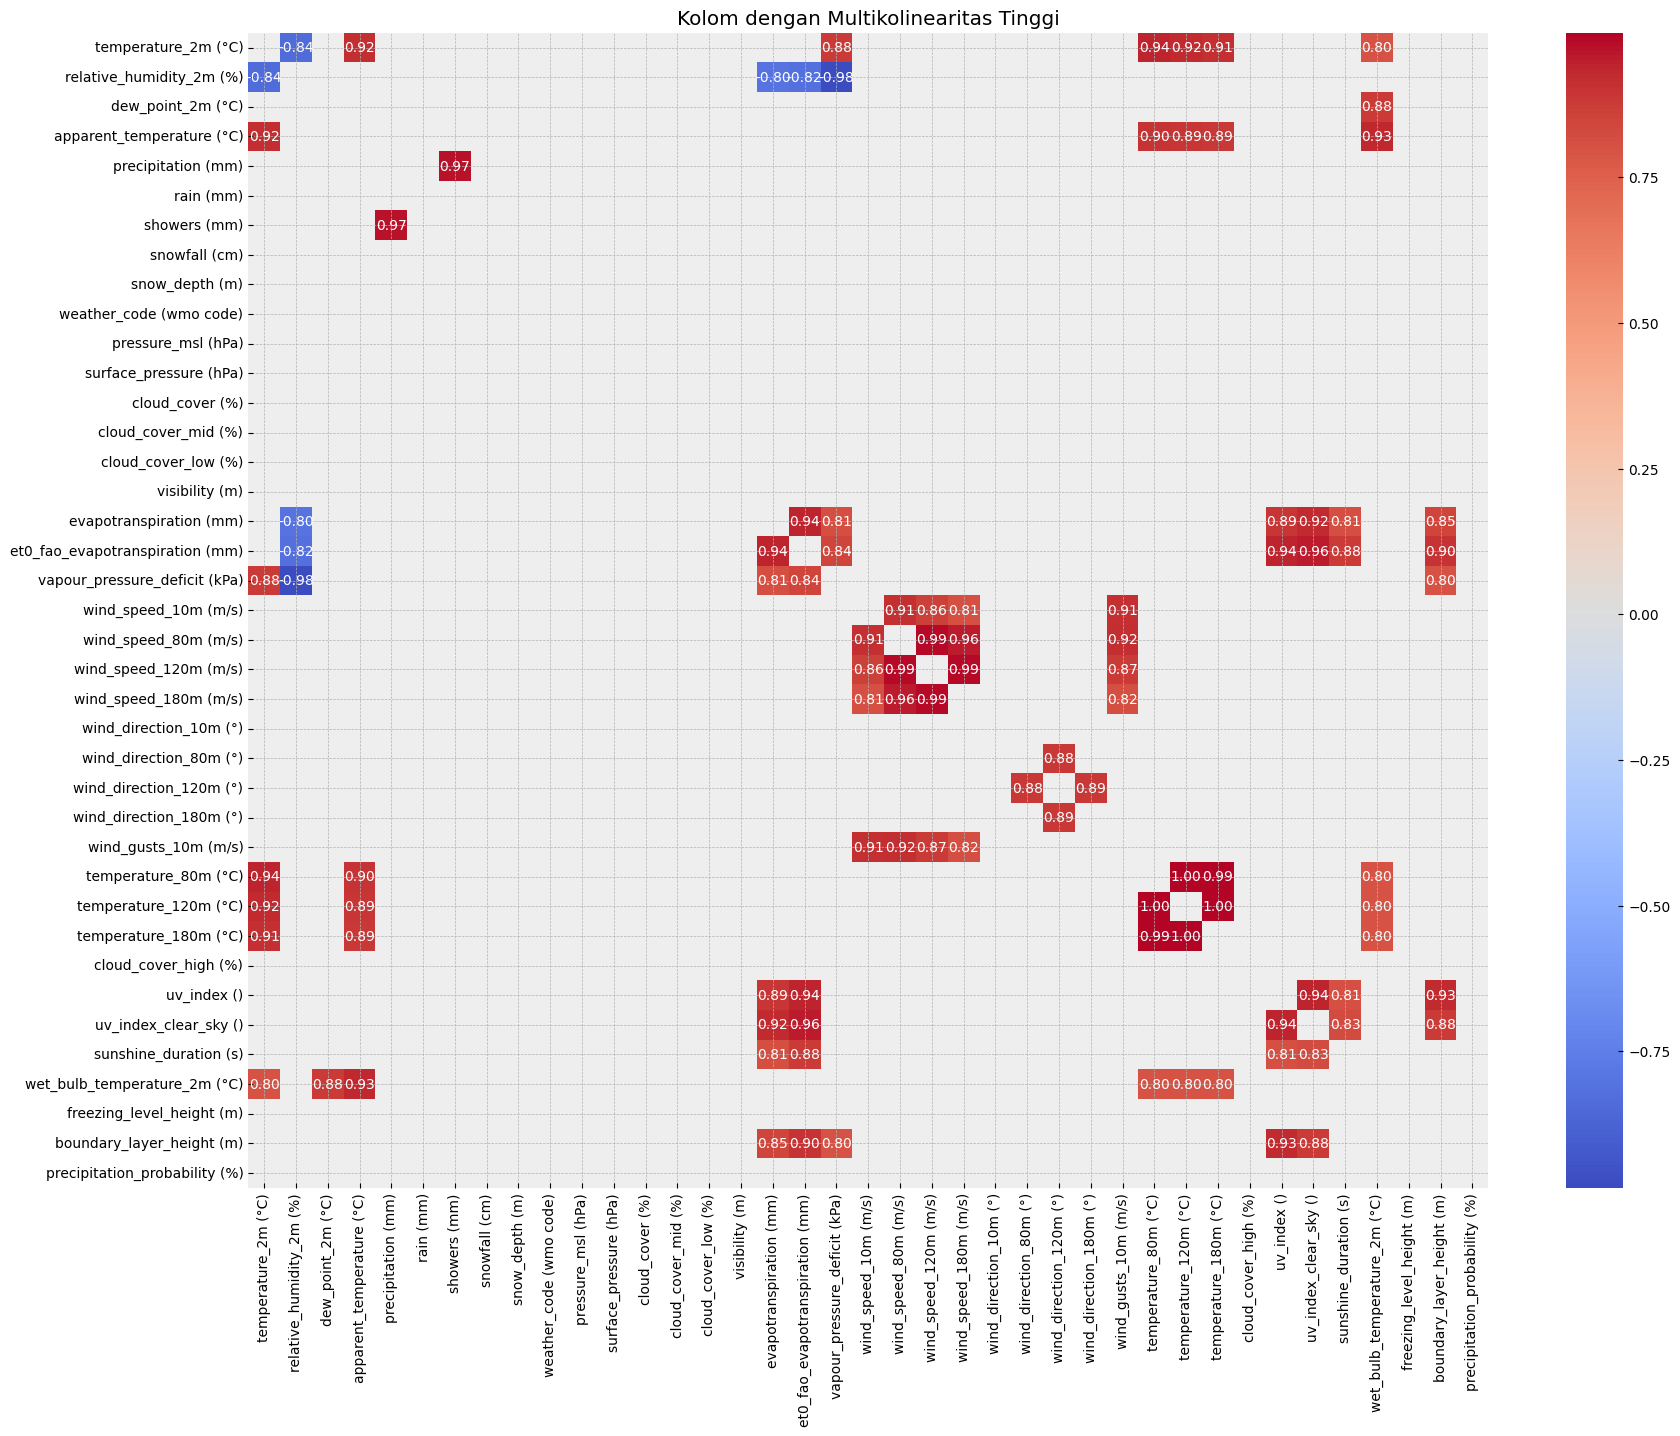

In [ ]:
high_corr = corr_matrix[(corr_matrix.abs() > 0.8) & (corr_matrix.abs() != 1.0)]
plt.figure(figsize=(20, 15))
sns.heatmap(high_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Kolom dengan Multikolinearitas Tinggi')
plt.show()

Terlihat disini bahwa terdapat beberapa fitur yang memiliki multikolinearitas tinggi, jika dibiarkan akan terdapat banyak fitur yang redundan sehingga bisa menambah noise.

### 2.6.1 Seleksi Lag & Rolling
Disini saya akan seleksi fitur yang benar-benar berkorelasi dengan target dan tidak hanya mengisi tempat yang akan menyebabkan overfitting.

In [ ]:
df_check = df_train.copy()
df_check['time'] = pd.to_datetime(df_check['time'])
df_check = df_check.sort_values(['region','time']).reset_index(drop=True)

miss = ['relative_humidity_2m (%)', 'cloud_cover (%)', 'wind_speed_10m (m/s)', 'uv_index_clear_sky ()', 'sunshine_duration (s)']
for col in miss:
    df_check[col] = df_check.groupby('region')[col].transform(lambda x: x.interpolate(method='linear', limit_direction='both'))
df_check = df_check.bfill().ffill()

cand_cols = ['temperature_2m (°C)', 'relative_humidity_2m (%)', 'cloud_cover (%)', 'pressure_msl (hPa)']
for col in cand_cols:
    for lag in [1,3,6,24]:
        df_check[f'{col}_lag{lag}'] = df_check.groupby('region')[col].shift(lag)
    for w in [3,6,12]:
        df_check[f'{col}_roll{w}'] = df_check.groupby('region')[col].transform(lambda x: x.shift(1).rolling(w,min_periods=1).mean())

all_lr = [c for c in df_check.columns if '_lag' in c or '_roll' in c]
corr_lr = df_check[all_lr+[target]].corr()[target].drop(target).sort_values(ascending=False)

THRESHOLD = 0.10
keep = corr_lr[corr_lr.abs() >= THRESHOLD]
drop = corr_lr[corr_lr.abs() <  THRESHOLD]

print(f'Dipakai ({len(keep)} fitur):')
print(keep.round(4))
print(f'\nDi drop ({len(drop)} fitur noise):')
print(drop.index.tolist())

Dipakai (12 fitur):
temperature_2m (°C)_lag3      0.2196
temperature_2m (°C)_roll6     0.2167
cloud_cover (%)_lag1          0.2012
temperature_2m (°C)_roll3     0.1969
cloud_cover (%)_roll3         0.1871
temperature_2m (°C)_lag6      0.1816
temperature_2m (°C)_lag24     0.1739
temperature_2m (°C)_lag1      0.1602
temperature_2m (°C)_roll12    0.1427
cloud_cover (%)_roll6         0.1367
cloud_cover (%)_lag3          0.1268
pressure_msl (hPa)_lag24     -0.1138
Name: precipitation_probability (%), dtype: float64

Di drop (16 fitur noise):
['relative_humidity_2m (%)_roll12', 'cloud_cover (%)_lag24', 'cloud_cover (%)_roll12', 'pressure_msl (hPa)_lag6', 'relative_humidity_2m (%)_lag1', 'pressure_msl (hPa)_roll12', 'relative_humidity_2m (%)_roll3', 'cloud_cover (%)_lag6', 'relative_humidity_2m (%)_roll6', 'pressure_msl (hPa)_roll6', 'relative_humidity_2m (%)_lag6', 'relative_humidity_2m (%)_lag3', 'pressure_msl (hPa)_lag3', 'relative_humidity_2m (%)_lag24', 'pressure_msl (hPa)_roll3', 'press

# 3. Preprocessing

## 3.1 Gabungkan Data
Sebelum memulai preprocessing, saya ingin menggabungkan data terlebih dahulu agar konsisten dan tidak ada perbedaan.

In [ ]:
df_train['is_train'] = 1
df_test['is_train']  = 0

df_all = pd.concat([df_train, df_test], ignore_index=True)
df_all['time'] = pd.to_datetime(df_all['time'])
df_all = df_all.sort_values(['region','time']).reset_index(drop=True) # Sort untuk interpolasi, lag, dan rolling.

In [ ]:
print(f'df_all: {df_all.shape}')

df_all: (8640, 44)


## 3.2 Kategorikal
Karena sebelumnya saya sudah melakukan *basic cleaning* pada numerikal, jadi saya sekarang akan melakukan hal yang sama terhadap kolom kategorikal dimana yang dapat kita lihat sebelumnya pada saat melakukan EDA, terdapat sebuah urutan sesuai dengan mean target.

In [58]:
le = LabelEncoder() # LabelEncoder untuk `region`karena Tree-based models sudah bisa handle integer biasa untuk fitur yang tidak punya urutan penting.
df_all['region'] = le.fit_transform(df_all['region'].astype(str))

weather_order = [['Clouds forming', 'Fog or ice fog', 'Rain shower slight', # Saya urutkan berdasarkan mean target
                   'Thunderstorm with hail', 'Thunderstorm no hail']]
# OrdinalEncoder untuk weather_category Karena kategori cuaca punya urutan ordinal berdasarkan intensitas yang dapat dilihat dari 2.5.
oe = OrdinalEncoder(categories=weather_order, handle_unknown='use_encoded_value', unknown_value=-1)
df_all['weather_category'] = oe.fit_transform(df_all[['weather_category']].astype(str))

## 3.3 Drop Kolom Kosong

In [56]:
# snowfall dan snow_depth = 0 semua, tidak ada informasi
df_all.drop(columns=['snowfall (cm)', 'snow_depth (m)'], inplace=True)
print('Dropped: snowfall (cm), snow_depth (m)')

Dropped: snowfall (cm), snow_depth (m)


# 4. Feature Engineering

## 4.1 Cyclic Time Features

In [ ]:
df_all['hour_sin']   = np.sin(2 * np.pi * df_all['time'].dt.hour / 24)
df_all['hour_cos']   = np.cos(2 * np.pi * df_all['time'].dt.hour / 24)
df_all['month_sin']  = np.sin(2 * np.pi * df_all['time'].dt.month / 12)
df_all['month_cos']  = np.cos(2 * np.pi * df_all['time'].dt.month / 12)
df_all['is_daytime'] = ((df_all['time'].dt.hour >= 6) & (df_all['time'].dt.hour <= 18)).astype(int)

print('Time features:', ['hour_sin','hour_cos','month_sin','month_cos','is_daytime'])

Time features: ['hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'is_daytime']


## 4.2 Interaksi antarfitur

In [ ]:
df_all['dew_spread']          = df_all['temperature_2m (°C)'] - df_all['dew_point_2m (°C)']
df_all['cloud_moisture']      = df_all['cloud_cover (%)'] * df_all['relative_humidity_2m (%)']
df_all['wind_shear']          = df_all['wind_speed_180m (m/s)'] - df_all['wind_speed_10m (m/s)']
df_all['temp_lapse']          = df_all['temperature_2m (°C)'] - df_all['temperature_180m (°C)']
df_all['total_cloud_combined']= (
    df_all['cloud_cover_low (%)']  * 0.5 +
    df_all['cloud_cover_mid (%)']  * 0.3 +
    df_all['cloud_cover_high (%)'] * 0.2
)

## 4.3 Lag dan Rolling Fitur

In [ ]:
# Temperature 2m: lag 1, 3, 6, 24 + rolling mean 3, 6, 12
for lag in [1, 3, 6, 24]:
    fn = f'temp2m_lag{lag}'
    df_all[fn] = df_all.groupby('region')['temperature_2m (°C)'].shift(lag)
    df_all[fn] = df_all.groupby('region')[fn].transform(lambda x: x.bfill())

for w in [3, 6, 12]:
    df_all[f'temp2m_roll{w}'] = df_all.groupby('region')['temperature_2m (°C)'].transform(
        lambda x: x.shift(1).rolling(w, min_periods=1).mean()
    )

# Cloud cover: lag 1, 3 + rolling mean 3, 6
for lag in [1, 3]:
    fn = f'cloud_lag{lag}'
    df_all[fn] = df_all.groupby('region')['cloud_cover (%)'].shift(lag)
    df_all[fn] = df_all.groupby('region')[fn].transform(lambda x: x.bfill())

for w in [3, 6]:
    df_all[f'cloud_roll{w}'] = df_all.groupby('region')['cloud_cover (%)'].transform(
        lambda x: x.shift(1).rolling(w, min_periods=1).mean()
    )

# Pressure: lag 24 saja
df_all['pressure_lag24'] = df_all.groupby('region')['pressure_msl (hPa)'].shift(24) # Shift agar tidak ada data leakage
df_all['pressure_lag24'] = df_all.groupby('region')['pressure_lag24'].transform(lambda x: x.bfill())

lag_roll_feats = [c for c in df_all.columns if 'lag' in c or 'roll' in c]
print(f'Lag/rolling features: {len(lag_roll_feats)}')
print(f'NaN: {df_all[lag_roll_feats].isnull().sum().sum()}')

Lag/rolling features: 12
NaN: 40


## 4.4 Pisahkan Data
Saya akan split data train dan test menjadi semula.

In [ ]:
train_proc = df_all[df_all['is_train'] == 1].copy().sort_values('time').reset_index(drop=True)
test_proc  = df_all[df_all['is_train'] == 0].copy()

In [ ]:
drop_cols = ['ID', 'time', 'is_train', target]
features  = [c for c in train_proc.columns if c not in drop_cols and c in test_proc.columns]

X      = train_proc[features]
y      = train_proc[target]
X_test = test_proc[features]

print(f'Training : {X.shape[0]} baris × {len(features)} fitur')
print(f'Test     : {X_test.shape[0]} baris × {len(features)} fitur')
print(f'\nSemua fitur ({len(features)}):')
for f in features: print(f'  {f}')

Training : 6528 baris × 62 fitur
Test     : 2112 baris × 62 fitur

Semua fitur (62):
  temperature_2m (°C)
  relative_humidity_2m (%)
  dew_point_2m (°C)
  apparent_temperature (°C)
  precipitation (mm)
  rain (mm)
  showers (mm)
  snowfall (cm)
  snow_depth (m)
  weather_code (wmo code)
  pressure_msl (hPa)
  surface_pressure (hPa)
  cloud_cover (%)
  cloud_cover_mid (%)
  cloud_cover_low (%)
  visibility (m)
  evapotranspiration (mm)
  et0_fao_evapotranspiration (mm)
  vapour_pressure_deficit (kPa)
  wind_speed_10m (m/s)
  wind_speed_80m (m/s)
  wind_speed_120m (m/s)
  wind_speed_180m (m/s)
  wind_direction_10m (°)
  wind_direction_80m (°)
  wind_direction_120m (°)
  wind_direction_180m (°)
  wind_gusts_10m (m/s)
  temperature_80m (°C)
  temperature_120m (°C)
  temperature_180m (°C)
  cloud_cover_high (%)
  uv_index ()
  uv_index_clear_sky ()
  sunshine_duration (s)
  wet_bulb_temperature_2m (°C)
  freezing_level_height (m)
  boundary_layer_height (m)
  region
  weather_category
  ho

# 5. Hyper Parameter Tuning (Optuna)



### Kenapa Optuna?
Optuna menggunakan TPE (Tree-structured Parzen Estimator) yaitu algoritma Bayesian yang belajar dari trial sebelumnya untuk menentukan area *search space* mana yang paling menjanjikan. Setiap trial berurutan bukan random, melainkan terinformasi oleh hasil trial sebelumnya. Jauh lebih efisien daripada grid search yang mencoba semua kombinasi.

In [ ]:
SEED      = 42
N_SPLITS  = 5
N_TRIALS  = 100

## 5.1 CV Score Function
Saya memisahkan fungsi CV Score karena fungsi akan dipanggil ratusan kali saat Optuna berjalan, sehingga memisahkannya dapat menghindari duplikasi kode yang dapat merusak konsistensi evaluasi semua model.

In [ ]:
def cv_rmse(model, X, y, n_splits=N_SPLITS):
    """TimeSeriesSplit CV — data harus sudah sorted by time."""
    tscv   = TimeSeriesSplit(n_splits=n_splits)
    scores = []
    for tr_i, val_i in tscv.split(X):
        X_tr,  X_val  = X.iloc[tr_i],  X.iloc[val_i]
        y_tr,  y_val  = y.iloc[tr_i],  y.iloc[val_i]
        model.fit(X_tr, y_tr)
        pred = np.clip(model.predict(X_val), 0, 100)
        scores.append(np.sqrt(mean_squared_error(y_val, pred)))
    return np.mean(scores), np.std(scores)

## 5.2 LightGBM

In [ ]:
def lgbm_objective(trial):
    params = {
        'n_estimators':      trial.suggest_int('n_estimators', 300, 2000),
        'learning_rate':     trial.suggest_float('learning_rate', 0.005, 0.3, log=True),
        'num_leaves':        trial.suggest_int('num_leaves', 20, 300),
        'max_depth':         trial.suggest_int('max_depth', 4, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample':         trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree':  trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha':         trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda':        trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'random_state': SEED, 'n_jobs': -1, 'verbose': -1
    }
    model = LGBMRegressor(**params)
    mean_rmse, _ = cv_rmse(model, X, y)
    return mean_rmse

print(f'Tuning LightGBM ({N_TRIALS} trials)...')
study_lgbm = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=SEED))
study_lgbm.optimize(lgbm_objective, n_trials=N_TRIALS, show_progress_bar=True)

best_lgbm = study_lgbm.best_params
best_lgbm_score = study_lgbm.best_value
print(f'\nLGBM Best CV RMSE: {best_lgbm_score:.4f}')
print(f'Best params: {best_lgbm}')

Tuning LightGBM (100 trials)...


  0%|          | 0/100 [00:00<?, ?it/s]


LGBM Best CV RMSE: 17.3299
Best params: {'n_estimators': 1455, 'learning_rate': 0.005573321923097855, 'num_leaves': 288, 'max_depth': 14, 'min_child_samples': 81, 'subsample': 0.5194688217255892, 'colsample_bytree': 0.5280491780288341, 'reg_alpha': 5.768396948449448e-07, 'reg_lambda': 4.04125871578664}


## 5.3 XGBoost

In [ ]:
def xgb_objective(trial):
    params = {
        'n_estimators':     trial.suggest_int('n_estimators', 300, 2000),
        'learning_rate':    trial.suggest_float('learning_rate', 0.005, 0.3, log=True),
        'max_depth':        trial.suggest_int('max_depth', 3, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'subsample':        trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma':            trial.suggest_float('gamma', 0, 5.0),
        'reg_alpha':        trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda':       trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'tree_method': 'hist', 'random_state': SEED, 'n_jobs': -1,
    }
    model = XGBRegressor(**params)
    mean_rmse, _ = cv_rmse(model, X, y)
    return mean_rmse

print(f'Tuning XGBoost ({N_TRIALS} trials)...')
study_xgb = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=SEED))
study_xgb.optimize(xgb_objective, n_trials=N_TRIALS, show_progress_bar=True)

best_xgb = study_xgb.best_params
best_xgb_score = study_xgb.best_value
print(f'\nXGB Best CV RMSE: {best_xgb_score:.4f}')
print(f'Best params: {best_xgb}')

Tuning XGBoost (100 trials)...


  0%|          | 0/100 [00:00<?, ?it/s]


XGB Best CV RMSE: 17.6555
Best params: {'n_estimators': 1891, 'learning_rate': 0.005575215174278104, 'max_depth': 6, 'min_child_weight': 20, 'subsample': 0.7512337215960312, 'colsample_bytree': 0.7830418573297317, 'gamma': 3.856020700005045, 'reg_alpha': 9.036161576858223, 'reg_lambda': 4.404221810134166}


## 5.4 CatBoost

In [ ]:
def cat_objective(trial):
    params = {
        'iterations':    trial.suggest_int('iterations', 300, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3, log=True),
        'depth':         trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg':   trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'random_strength':     trial.suggest_float('random_strength', 1e-8, 10.0, log=True),
        'border_count':  trial.suggest_int('border_count', 32, 255),
        'loss_function': 'RMSE',
        'random_seed': SEED, 'verbose': 0, 'allow_writing_files': False
    }
    model = CatBoostRegressor(**params)
    mean_rmse, _ = cv_rmse(model, X, y)
    return mean_rmse

print(f'Tuning CatBoost ({N_TRIALS} trials)...')
study_cat = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=SEED))
study_cat.optimize(cat_objective, n_trials=N_TRIALS, show_progress_bar=True)

best_cat = study_cat.best_params
best_cat_score = study_cat.best_value
print(f'\nCatBoost Best CV RMSE: {best_cat_score:.4f}')
print(f'Best params: {best_cat}')

Tuning CatBoost (100 trials)...


  0%|          | 0/100 [00:00<?, ?it/s]


CatBoost Best CV RMSE: 16.7316
Best params: {'iterations': 996, 'learning_rate': 0.006541993352330505, 'depth': 7, 'l2_leaf_reg': 0.11270771867487642, 'bagging_temperature': 0.9736776112732786, 'random_strength': 2.3236378953795206e-05, 'border_count': 87}


HASIL OPTUNA TUNING
LGBM     CV RMSE: 17.3299
XGBoost  CV RMSE: 17.6555
CatBoost CV RMSE: 16.7316


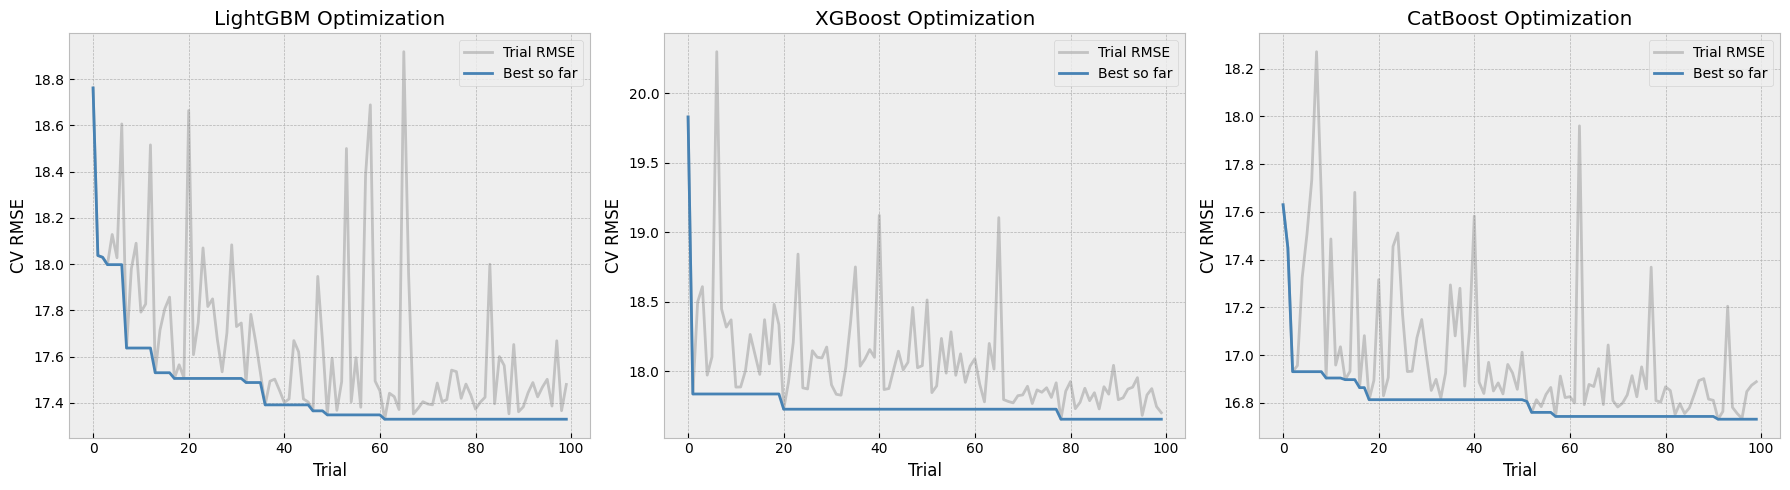

In [ ]:
print('='*50)
print('HASIL OPTUNA TUNING')
print('='*50)
print(f'LGBM     CV RMSE: {best_lgbm_score:.4f}')
print(f'XGBoost  CV RMSE: {best_xgb_score:.4f}')
print(f'CatBoost CV RMSE: {best_cat_score:.4f}')

# Plot optimization history per model
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, study, name in zip(axes,
    [study_lgbm, study_xgb, study_cat],
    ['LightGBM', 'XGBoost', 'CatBoost']
):
    vals = [t.value for t in study.trials if t.value is not None]
    best = np.minimum.accumulate(vals)
    ax.plot(vals, alpha=0.4, color='gray', label='Trial RMSE')
    ax.plot(best, color='steelblue', linewidth=2, label='Best so far')
    ax.set_title(f'{name} Optimization')
    ax.set_xlabel('Trial')
    ax.set_ylabel('CV RMSE')
    ax.legend()

plt.tight_layout()
plt.show()

Dapat dilihat dari ```best so far``` setiap model sudah stabil dan tidak ada penurunan kembali, memaksimalkan skor terbaik.

# 6. Modelling

## 6.1 Weighted Voting Ensemble

Daripada hanya menaruh *weight* pada setiap model dengan ragu-ragu, saya menggunakan *weight voting regressor* dimana model yang CV RMSEnya lebih kecil dapat *weight* lebih besar.

In [52]:
# Hitung bobot berdasarkan CV score
scores = np.array([best_lgbm_score, best_xgb_score, best_cat_score])
inv_scores = 1.0 / scores
weights = inv_scores / inv_scores.sum()

print('Weighted Ensemble Weights:')
for name, w, s in zip(['LGBM','XGBoost','CatBoost'], weights, scores):
    print(f'  {name:10s}: weight={w:.4f}  (CV RMSE={s:.4f})')

# Build final models dengan best hyperparameters
lgbm_final = LGBMRegressor(**{**best_lgbm, 'random_state': SEED, 'n_jobs': -1, 'verbose': -1})

xgb_final  = XGBRegressor(**{**best_xgb,  'random_state': SEED, 'n_jobs': -1,
                              'tree_method': 'hist'})

cat_params = {k: v for k, v in best_cat.items()}
cat_final  = CatBoostRegressor(**cat_params, loss_function='RMSE',
                                random_seed=SEED, verbose=0, allow_writing_files=False)

ensemble = VotingRegressor(
    estimators=[
        ('lgbm', lgbm_final),
        ('xgb',  xgb_final),
        ('cat',  cat_final)
    ],
    weights=weights.tolist()
)

print('\nFitting weighted ensemble pada full training data...')
ensemble.fit(X, y)
print('Selesai!')

Weighted Ensemble Weights:
  LGBM      : weight=0.3314  (CV RMSE=17.3299)
  XGBoost   : weight=0.3253  (CV RMSE=17.6555)
  CatBoost  : weight=0.3433  (CV RMSE=16.7316)

Fitting weighted ensemble pada full training data...
Selesai!


## 6.2Predict & Post-Processing

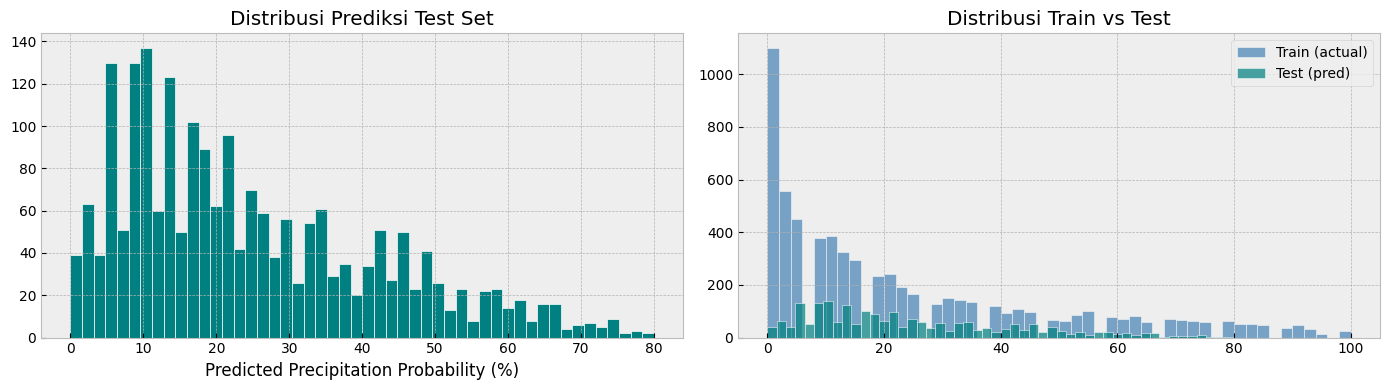

Min: 0.00  Max: 80.00  Mean: 24.67


In [53]:
test_preds = np.clip(ensemble.predict(X_test), 0, 100)
test_preds = np.round(np.clip(ensemble.predict(X_test), 0, 100)).astype(int)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].hist(test_preds, bins=50, color='teal', edgecolor='white')
axes[0].set_title('Distribusi Prediksi Test Set')
axes[0].set_xlabel('Predicted Precipitation Probability (%)')

axes[1].hist(y, bins=50, color='steelblue', edgecolor='white', alpha=0.7, label='Train (actual)')
axes[1].hist(test_preds, bins=50, color='teal', edgecolor='white', alpha=0.7, label='Test (pred)')
axes[1].set_title('Distribusi Train vs Test')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f'Min: {test_preds.min():.2f}  Max: {test_preds.max():.2f}  Mean: {test_preds.mean():.2f}')

# 7. Evaluasi

## 7.1 Feature Importance

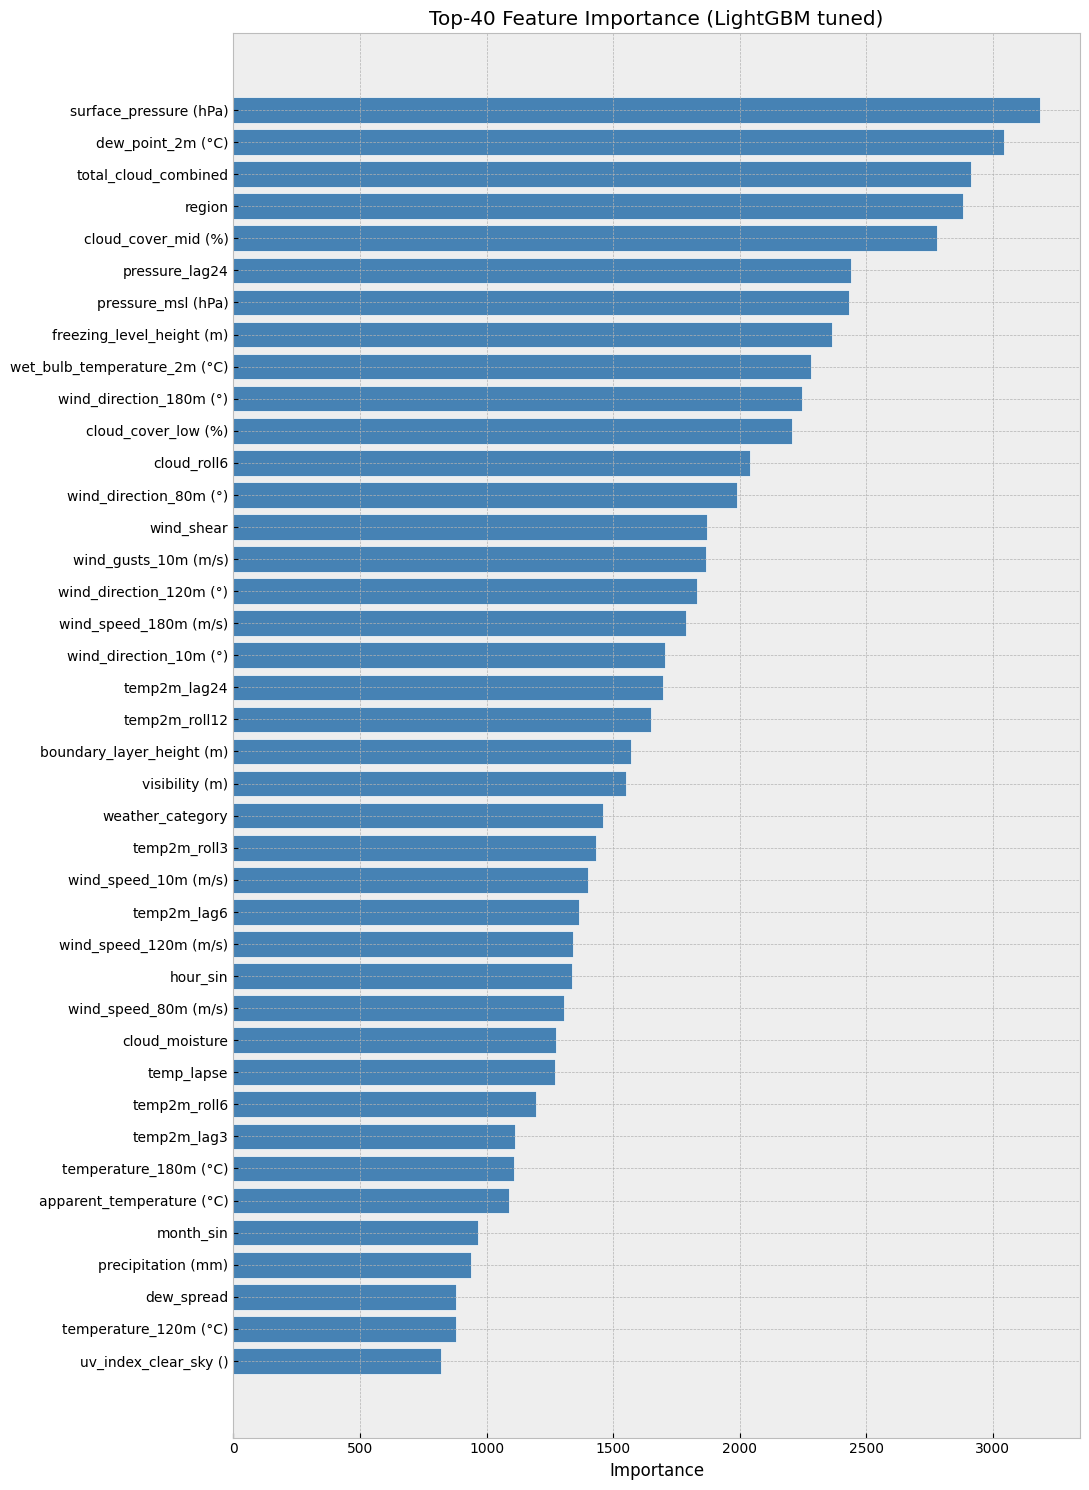

In [54]:
# Gunakan LGBM (sudah fitted dalam ensemble) untuk feature importance
lgbm_fi = ensemble.estimators_[0]  # lgbm adalah estimator pertama

importance_df = pd.DataFrame({
    'feature':    features,
    'importance': lgbm_fi.feature_importances_
}).sort_values('importance', ascending=False)

top_n = min(40, len(features))
plt.figure(figsize=(11, top_n * 0.35 + 1))
top = importance_df.head(top_n)
plt.barh(top['feature'][::-1], top['importance'][::-1], color='steelblue', edgecolor='white')
plt.title(f'Top-{top_n} Feature Importance (LightGBM tuned)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

Terlihat top 5 fitur sebelumnya masih menjadi salah satu fitur yang paling penting digabung dengan fitur fisik baru yang telah kita tambahkan.

## 8. Submission

In [55]:
submission = pd.DataFrame({
    'ID': test_proc['ID'].values,
    'precipitation_probability (%)': test_preds
})
submission = submission.set_index('ID').reindex(sample_submission['ID']).reset_index()

submission.to_csv('submission_bismillah.csv', index=False)
print(f'Saved! Shape: {submission.shape}')
display(submission.head(10))

Saved! Shape: (2112, 2)


ID  precipitation_probability (%)
0  region 1_2025-12-21_00                             10
1  region 2_2025-12-21_00                             49
2  region 3_2025-12-21_00                             17
3  region 4_2025-12-21_00                             17
4  region 5_2025-12-21_00                             22
5  region 6_2025-12-21_00                             16
6  region 7_2025-12-21_00                             16
7  region 8_2025-12-21_00                             26
8  region 1_2025-12-21_01                              9
9  region 2_2025-12-21_01                             46